In [37]:
import os

train_dir = '/Users/ishabhansali/Downloads/federated_learning_new/cleaned/Training/pituitary'
# List all files with image extensions, replace with your specific image formats if needed
image_files = [f for f in os.listdir(train_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

num_images = len(image_files)
print(f'Total images in training set: {num_images}')


Total images in training set: 1457


### Counting Images in a Directory
This code block counts the number of image files in a specified directory (e.g., the "pituitary" class in your training set). This helps verify dataset integrity and understand how many samples are present before further processing.

## Building a List of All Images and Labels from Multiple Classes

This code walks through a root training directory and iterates over all subfolders (corresponding to each brain tumor class).

It collects the full file paths of all images for every class and builds a label list matching those paths to their class.

Supported image formats are .jpg and .png. 

After running, one gets the total image count, example image paths, example labels, and a check for any missing image files.

In [ ]:
import os
import random
import numpy as np


# 1. Set your root directory correctly:
root_dir = "/Users/ishabhansali/Downloads/federated_learning_new/cleaned/Training"

# 2. Define folder names for each class:
class_labels = ["glioma", "meningioma", "notumor", "pituitary"]
label_map = {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

all_images = []   # will store full paths
all_labels = []   # will store corresponding integer labels

# 3. Loop through each class and each image file to build the datasets:
for cls in class_labels:
    class_dir = os.path.join(root_dir, cls)     # e.g. .../Training/glioma
    for fname in os.listdir(class_dir):
        # Make sure to match file extensions (add more types if needed)
        if fname.lower().endswith(".jpg") or fname.lower().endswith(".png"):
            img_path = os.path.join(class_dir, fname)   # e.g. .../Training/glioma/Tr-gl_0010.jpg
            all_images.append(img_path)
            all_labels.append(label_map[cls])

# 4. Print to verify:
print(f"Total images collected: {len(all_images)}")
print(f"First 5 image paths: {all_images[:5]}")
print(f"First 5 labels: {all_labels[:5]}")

# 5. Optional: Check for any missing files (should be zero!)
missing_files = [img for img in all_images if not os.path.exists(img)]
print(f"Missing file count: {len(missing_files)}")
if missing_files:
    print("Example missing file:", missing_files[:5])



Total images collected: 5712
First 5 image paths: ['/Users/ishabhansali/Downloads/federated_learning_new/cleaned/Training/glioma/Tr-gl_1135.jpg', '/Users/ishabhansali/Downloads/federated_learning_new/cleaned/Training/glioma/Tr-gl_0559.jpg', '/Users/ishabhansali/Downloads/federated_learning_new/cleaned/Training/glioma/Tr-gl_1121.jpg', '/Users/ishabhansali/Downloads/federated_learning_new/cleaned/Training/glioma/Tr-gl_0217.jpg', '/Users/ishabhansali/Downloads/federated_learning_new/cleaned/Training/glioma/Tr-gl_1109.jpg']
First 5 labels: [0, 0, 0, 0, 0]
Missing file count: 0


This section describes a function and process for splitting a labeled dataset in a highly non-IID fashion among multiple clients for federated learning experiments.

The function, seed_split_images_non_iid, takes all image paths and their integer labels, and assigns them to n_clients so that each client receives a constrained, but class-imbalanced set of samples. The splitting honors minimum and maximum image constraints per client.

For each class, images are shuffled (using a fixed random seed for reproducibility) and then distributed across clients by randomly allocating sample counts (respecting the specified min/max bounds for each allocation).

Each client ends up with a list of (absolute path, class label) tuples, and the split is intentionally "non-IID”—some clients may have many samples of a few classes and very few (or none) of other classes.

After splitting, the summary code prints for each client: the total number of images received, a few sample absolute file paths for quick verification, and a divider for readability.

This approach simulates realistic federated learning deployment scenarios where different organizations or silos have very different class distributions in their local data. Such splits are critical for benchmarking algorithms like FedAvg and FedProx under challenging data heterogeneity conditions.

In [ ]:
# Step 2: Non-IID client splitting, using full file paths
# Step 2: Non-IID client splitting, using full file paths
def seed_split_images_non_iid(image_paths, labels, n_clients=4, min_images=50, max_images=600, seed=12345):
    random.seed(seed)
    np.random.seed(seed)
    class_images = {}
    for img, label in zip(image_paths, labels):
        class_images.setdefault(label, []).append(img)
    client_data = {i: [] for i in range(n_clients)}
    for label, imgs in class_images.items():
        random.shuffle(imgs)
        total_images = len(imgs)
        allocations = []
        remaining = total_images
        for i in range(n_clients):
            if i == n_clients - 1:
                allocations.append(remaining)
            else:
                max_for_client = min(max_images, remaining - (min_images * (n_clients - i - 1)))
                min_for_client = min_images
                if max_for_client < min_for_client:
                    min_for_client = max_for_client
                allocated = random.randint(min_for_client, max_for_client) if max_for_client >= min_for_client else 0
                allocations.append(allocated)
                remaining -= allocated
        start_idx = 0
        for client_id, alloc in enumerate(allocations):
            client_data[client_id].extend([(imgs[i], label) for i in range(start_idx, start_idx + alloc)])
            start_idx += alloc
    return client_data

clients_data = seed_split_images_non_iid(all_images, all_labels, n_clients=4, min_images=50, max_images=600, seed=12345)

# Step 3: Print summary and content (paths and class counts) for each client
for client_id, data in clients_data.items():
    print(f'Client {client_id}: {len(data)} images')
    print('Sample paths:')
    for img_path, _ in data[:5]:
        print(img_path)  # This should show absolute file paths!
    print('-' * 50)


Client 0: 1455 images
Sample paths:
/Users/ishabhansali/Downloads/federated_learning_new/cleaned/Training/glioma/Tr-gl_0308.jpg
/Users/ishabhansali/Downloads/federated_learning_new/cleaned/Training/glioma/Tr-gl_0712.jpg
/Users/ishabhansali/Downloads/federated_learning_new/cleaned/Training/glioma/Tr-gl_0390.jpg
/Users/ishabhansali/Downloads/federated_learning_new/cleaned/Training/glioma/Tr-gl_0191.jpg
/Users/ishabhansali/Downloads/federated_learning_new/cleaned/Training/glioma/Tr-gl_0373.jpg
--------------------------------------------------
Client 1: 937 images
Sample paths:
/Users/ishabhansali/Downloads/federated_learning_new/cleaned/Training/glioma/Tr-gl_0348.jpg
/Users/ishabhansali/Downloads/federated_learning_new/cleaned/Training/glioma/Tr-gl_0374.jpg
/Users/ishabhansali/Downloads/federated_learning_new/cleaned/Training/glioma/Tr-gl_0119.jpg
/Users/ishabhansali/Downloads/federated_learning_new/cleaned/Training/glioma/Tr-gl_0030.jpg
/Users/ishabhansali/Downloads/federated_learning_n

This code performs a train-test split for each federated client’s local dataset, ensuring reproducibility and label stratification. It takes a dictionary (client_data) where each client is mapped to a list of (image_path, label) tuples, and splits each client’s data into training and testing subsets according to the specified test fraction.

The steps:

Iterates over each client’s dataset.

Separates image paths and labels.

Uses sklearn’s train_test_split with stratification on labels to preserve class distributions per client.

Stores the train and test splits back into a dictionary structure for all clients.

Prints out the number of train and test samples and sample image paths per client for verification.

This is essential to simulate federated learning conditions where each client operates on their private train/test datasets. It maintains class balance within clients while allowing realistic data heterogeneity.

In [ ]:
from sklearn.model_selection import train_test_split

def split_client_train_test(client_data, test_size=0.2, seed=12345):
    """
    Splits each client's list into train/test sets.
    Args:
        client_data: dict like {client_id: [(img_path, label), ...]}
        test_size: fraction of test samples per client (e.g., 0.2)
        seed: random seed for reproducibility
    Returns:
        dict with {client_id: {'train': [...], 'test': [...]}}
    """
    client_train_test = {}
    for client_id, data in client_data.items():
        images, labels = zip(*data)
        train_imgs, test_imgs, train_labels, test_labels = train_test_split(
            images, labels, test_size=test_size, random_state=seed, stratify=labels)
        client_train_test[client_id] = {
            'train': list(zip(train_imgs, train_labels)),
            'test': list(zip(test_imgs, test_labels))
        }
    return client_train_test

# Usage:
clients_train_test = split_client_train_test(clients_data, test_size=0.2, seed=12345)

# Preview the split for one client:
for client_id, splits in clients_train_test.items():
    print(f'Client {client_id} - Train: {len(splits["train"])}, Test: {len(splits["test"])}')
    print('Sample train image:', splits["train"][0][0])
    print('Sample test image:', splits["test"][0][0])
    print('-' * 40)


Client 0 - Train: 1164, Test: 291
Sample train image: /Users/ishabhansali/Downloads/federated_learning_new/cleaned/Training/pituitary/Tr-pi_0888.jpg
Sample test image: /Users/ishabhansali/Downloads/federated_learning_new/cleaned/Training/glioma/Tr-gl_0243.jpg
----------------------------------------
Client 1 - Train: 749, Test: 188
Sample train image: /Users/ishabhansali/Downloads/federated_learning_new/cleaned/Training/glioma/Tr-gl_0116.jpg
Sample test image: /Users/ishabhansali/Downloads/federated_learning_new/cleaned/Training/glioma/Tr-gl_0259.jpg
----------------------------------------
Client 2 - Train: 1044, Test: 261
Sample train image: /Users/ishabhansali/Downloads/federated_learning_new/cleaned/Training/pituitary/Tr-piTr_0001.jpg
Sample test image: /Users/ishabhansali/Downloads/federated_learning_new/cleaned/Training/glioma/Tr-gl_0948.jpg
----------------------------------------
Client 3 - Train: 1612, Test: 403
Sample train image: /Users/ishabhansali/Downloads/federated_learn

## Local Client Model Training
For each client, a separate ResNet18 model is initialized and fine-tuned on that client’s local training dataset.

Each training cycle consists of num_epochs epochs involving:

Training the model on client-specific training data,

Evaluating the model on client-specific test data,

Recording training and test loss and accuracy.

The best performing model for each client—determined by highest test accuracy—is saved to a file named uniquely per client.

This ensures that each client has a locally optimized model, independent of other clients.

This step is crucial for benchmarking against federated learning methods (FedAvg, FedProx) to understand performance differences between localized and federated models.

In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

import random
import numpy as np

seed = 12345
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class BrainTumorDataset(Dataset):
    def __init__(self, data_tuples, transform=None):
        self.data = data_tuples
        self.transform = transform
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def train_one_epoch(model, dataloader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels).item()
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects / len(dataloader.dataset)
    return epoch_loss, epoch_acc

def evaluate(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels).item()
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects / len(dataloader.dataset)
    return epoch_loss, epoch_acc

num_epochs = 4
batch_size = 32
learning_rate = 0.001
results = {}

for client_id, splits in clients_train_test.items():
    print(f'\nTraining Client {client_id} ResNet18 Model')
    train_dataset = BrainTumorDataset(splits['train'], transform=transform)
    test_dataset = BrainTumorDataset(splits['test'], transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 4)
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    best_acc = 0.0  # Track best test accuracy
    for epoch in range(num_epochs):
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer)
        test_loss, test_acc = evaluate(model, test_loader, criterion)
        print(f'Epoch {epoch+1}/{num_epochs} | '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | '
              f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

        # Save model if this epoch's test accuracy is the best so far
        if test_acc > best_acc:
            best_acc = test_acc
            save_path = f'client_{client_id}_best_model.pth'
            torch.save(model.state_dict(), save_path)
            print(f'Saved best model for client {client_id} at epoch {epoch+1} with test acc {test_acc:.4f}')

    results[client_id] = {
        'train_loss': train_loss,
        'train_acc': train_acc,
        'test_loss': test_loss,
        'test_acc': test_acc
    }



Training Client 0 ResNet18 Model
Epoch 1/4 | Train Loss: 0.6336, Train Acc: 0.7749 | Test Loss: 0.3137, Test Acc: 0.8900
Saved best model for client 0 at epoch 1 with test acc 0.8900
Epoch 2/4 | Train Loss: 0.3239, Train Acc: 0.8909 | Test Loss: 0.2500, Test Acc: 0.9107
Saved best model for client 0 at epoch 2 with test acc 0.9107
Epoch 3/4 | Train Loss: 0.1892, Train Acc: 0.9278 | Test Loss: 0.6930, Test Acc: 0.8041
Epoch 4/4 | Train Loss: 0.1627, Train Acc: 0.9459 | Test Loss: 0.8746, Test Acc: 0.7216

Training Client 1 ResNet18 Model
Epoch 1/4 | Train Loss: 0.6631, Train Acc: 0.7704 | Test Loss: 29.0717, Test Acc: 0.1702
Saved best model for client 1 at epoch 1 with test acc 0.1702
Epoch 2/4 | Train Loss: 0.3836, Train Acc: 0.8718 | Test Loss: 0.7754, Test Acc: 0.7713
Saved best model for client 1 at epoch 2 with test acc 0.7713
Epoch 3/4 | Train Loss: 0.2423, Train Acc: 0.9146 | Test Loss: 0.7872, Test Acc: 0.7287
Epoch 4/4 | Train Loss: 0.1451, Train Acc: 0.9453 | Test Loss: 0.51

This code snippet implements a simple manual FedAvg aggregation of locally trained client models to form a global model, by averaging the weights of the saved client models:

It first creates an initialized global ResNet18 model matching your problem (4 output classes).

It loads the state dictionaries (weights) of all client models (from .pth files).

It then sums up the parameters for each weight key across all client models.

After summing, it divides each summed parameter by the number of clients to calculate the average weights.

Finally, it loads this averaged weight dictionary into the global model.

This effectively reproduces the core FedAvg step of parameter aggregation in federated learning, but manually and offline by reading client models from disk instead of during training.

In [ ]:
import torch
from torchvision import models

client_model_paths = [  # list all your best model .pth files in order
    'client_0_best_model.pth',
    'client_1_best_model.pth',
    'client_2_best_model.pth',
    'client_3_best_model.pth',

 
]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize a global ResNet18 model architecture
global_model = models.resnet18(weights=None)
num_ftrs = global_model.fc.in_features
global_model.fc = torch.nn.Linear(num_ftrs, 4)
global_model.to(device)

# Load and accumulate
global_dict = global_model.state_dict()
for key in global_dict:
    global_dict[key] = 0

for model_path in client_model_paths:
    client_dict = torch.load(model_path, map_location=device)
    for key in global_dict:
        global_dict[key] += client_dict[key]

for key in global_dict:
    global_dict[key] = global_dict[key] / len(client_model_paths)

global_model.load_state_dict(global_dict)


<All keys matched successfully>

This code creates a dataset and dataloader to load the global holdout test set for your federated learning experiment.

It reads all class folders within the cleaned/Testing directory.

It creates a label_map dictionary to map class names to integer labels.

For each image file in each class folder, it stores the full path and corresponding label as a tuple in test_data.

Then it creates a PyTorch dataset (BrainTumorDataset) and a dataloader (holdout_loader) to feed images in batches for evaluation.

In [ ]:
import os

test_dir = 'cleaned/Testing'
class_names = sorted(os.listdir(test_dir))
label_map = {cls_name: i for i, cls_name in enumerate(class_names)}

test_data = []
for cls in class_names:
    class_folder = os.path.join(test_dir, cls)
    for img_fname in os.listdir(class_folder):
        test_data.append((os.path.join(class_folder, img_fname), label_map[cls]))

holdout_dataset = BrainTumorDataset(test_data, transform=transform)
holdout_loader = DataLoader(holdout_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
criterion = torch.nn.CrossEntropyLoss()
test_loss, test_acc = evaluate(global_model, holdout_loader, criterion)
print(f'Global Model - Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')


Global Model - Test Loss: 1.2566, Test Acc: 0.3638


In [ ]:
torch.save(global_model.state_dict(), 'global_model_round0.pth')


This code snippet implements a single round of FedProx federated training across 4 clients:

Defines a reproducible setup with seeds and device selection

Defines a custom dataset class for brain tumor images with transformations

Defines the FedProx local training step where each client model minimizes cross-entropy loss plus a proximal regularization term to keep close to the global weights

Defines a FedAvg aggregation function averaging all client weights to update the global model

Defines evaluation function to measure loss and accuracy

Prepares train data loaders per client from pre-split client datasets

Initializes global ResNet18 model and criterion

In a single federated round: for each client

Load global weights

Train locally using FedProx

Collect client weights

Aggregate all client weights into a new global model

(Optionally) Evaluate global model on a holdout test set

It lets the global model learn from non-IID client data in a federated way, mitigating client drift using FedProx's proximal term. To run multiple rounds, you would wrap the training-aggregation-evaluation in a loop and update the global model across rounds.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import random
import numpy as np

# Seed for reproducibility
seed = 12345
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Your brain tumor dataset definition
class BrainTumorDataset(Dataset):
    def __init__(self, data_tuples, transform=None):
        self.data = data_tuples
        self.transform = transform
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# Use the same transform as your baseline code
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# --- FedProx local training function ---
def fedprox_train(model, global_weights, train_loader, criterion, optimizer, device, mu=0.01, local_epochs=1):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0

    for epoch in range(local_epochs):
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            prox_reg = 0.0
            for param_local, param_global in zip(model.parameters(), global_weights):
                prox_reg += torch.norm(param_local - param_global.to(device)) ** 2
            loss += (mu / 2) * prox_reg
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels).item()
            total_samples += inputs.size(0)

    avg_loss = running_loss / total_samples
    avg_acc = running_corrects / total_samples
    return model.state_dict(), avg_loss, avg_acc

# --- FedAvg aggregation function ---
def fedavg_aggregate(global_model, client_states):
    global_dict = global_model.state_dict()
    for key in global_dict.keys():
        global_dict[key] = torch.stack([client_states[i][key].float() for i in range(len(client_states))], 0).mean(0)
    global_model.load_state_dict(global_dict)
    return global_model.state_dict()

# --- Evaluation function ---
def test_model(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels).item()
            total_samples += inputs.size(0)
    avg_loss = running_loss / total_samples
    avg_acc = running_corrects / total_samples
    return avg_loss, avg_acc

# --- Prepare DataLoaders for each client ---
batch_size = 32

client_train_loaders = {}
for client_id, splits in clients_train_test.items():
    train_data = BrainTumorDataset(splits['train'], transform=transform)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    client_train_loaders[client_id] = train_loader

# Prepare a global test loader (use as needed)
# If you have a global holdout test set as `holdout_test_set`:
# test_loader = DataLoader(BrainTumorDataset(holdout_test_set, transform=transform), batch_size=batch_size, shuffle=False)

# --- Main FedProx Federated Training Round ---
num_classes = 4
learning_rate = 0.001
mu = 0.01
local_epochs = 1

global_model = models.resnet18(weights=None)
num_ftrs = global_model.fc.in_features
global_model.fc = nn.Linear(num_ftrs, num_classes)
global_model.to(device)

criterion = nn.CrossEntropyLoss()

client_states = []
for client_id, train_loader in client_train_loaders.items():
    client_model = models.resnet18(weights=None)
    client_model.fc = nn.Linear(num_ftrs, num_classes)
    client_model.to(device)
    client_model.load_state_dict(global_model.state_dict())
    optimizer = optim.Adam(client_model.parameters(), lr=learning_rate)
    state_dict, train_loss, train_acc = fedprox_train(
        client_model,
        [param.data.clone() for param in global_model.parameters()],
        train_loader,
        criterion,
        optimizer,
        device,
        mu=mu,
        local_epochs=local_epochs
    )
    print(f'Client {client_id} - FedProx Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}')
    client_states.append(state_dict)

# --- Federated Averaging Step ---
global_state = fedavg_aggregate(global_model, client_states)
global_model.load_state_dict(global_state)

# --- Test Global Model ---
# Uncomment and supply your test_loader if you have a holdout test set:
# test_loss, test_acc = test_model(global_model, test_loader, criterion, device)
# print(f'Global Model Test Loss: {test_loss:.4f} Test Acc: {test_acc:.4f}')


Client 0 - FedProx Train Loss: 1.6743 Acc: 0.5593
Client 1 - FedProx Train Loss: 1.5854 Acc: 0.5928
Client 2 - FedProx Train Loss: 1.7795 Acc: 0.5115
Client 3 - FedProx Train Loss: 1.4845 Acc: 0.6799


<All keys matched successfully>

The provided code sets up evaluation of the global FedProx model on each client’s local test dataset.

Here is what it does:

Creates a PyTorch DataLoader for each client’s test split using the existing clients_train_test dictionary and your brain tumor dataset class.

Defines an evaluation function evaluate() that calculates average loss and accuracy over the test data.

Then, for every client, runs the evaluation on the global federated model and prints the test loss and accuracy.

In [ ]:
# Assuming you already have:
# - global_model: the updated/aggregated global model after FedProx+FedAvg
# - clients_train_test: dict mapping client_id -> {'train': [...], 'test': [...]}
# - BrainTumorDataset: your dataset class
# - transform: your image transform for ResNet
# - device: gpu/cpu setup
# - batch_size: batch size used in evaluation
# - criterion: loss function

from torch.utils.data import DataLoader

# Create test loaders for all clients
client_test_loaders = {}
for client_id, splits in clients_train_test.items():
    test_data = BrainTumorDataset(splits['test'], transform=transform)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    client_test_loaders[client_id] = test_loader

# Define evaluation function if not already present
def evaluate(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels).item()
            total_samples += inputs.size(0)
    epoch_loss = running_loss / total_samples
    epoch_acc = running_corrects / total_samples
    return epoch_loss, epoch_acc

# Evaluate the global FedProx model on each client's local test set
for client_id, test_loader in client_test_loaders.items():
    test_loss, test_acc = evaluate(global_model, test_loader, criterion)
    print(f'FedProx Global Model on Client {client_id} Test Set — Loss: {test_loss:.4f}, Acc: {test_acc:.4f}')


FedProx Global Model on Client 0 Test Set — Loss: 1.5196, Acc: 0.2784
FedProx Global Model on Client 1 Test Set — Loss: 1.3434, Acc: 0.4043
FedProx Global Model on Client 2 Test Set — Loss: 1.2729, Acc: 0.3678
FedProx Global Model on Client 3 Test Set — Loss: 2.3080, Acc: 0.0397


In [ ]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms

# ---------- Parameters ----------
test_dir = './cleaned/Testing'  # Path to your global holdout/validation directory
batch_size = 32  # or whatever batch size you use
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Use same transforms as in training
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# ---------- Dataset Construction ----------
class_names = sorted(os.listdir(test_dir))
label_map = {cls_name: i for i, cls_name in enumerate(class_names)}
test_data = []

for cls in class_names:
    class_folder = os.path.join(test_dir, cls)
    for img_fname in os.listdir(class_folder):
        img_path = os.path.join(class_folder, img_fname)
        if os.path.isfile(img_path):  # Make sure it's a file
            test_data.append((img_path, label_map[cls]))

# Confirm filepaths
print("Example holdout samples:", test_data[:3])

# ---------- Dataset & Loader ----------
class BrainTumorDataset(Dataset):
    def __init__(self, data_tuples, transform=None):
        self.data = data_tuples
        self.transform = transform
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        # Ensure path-like and not already tensor
        if isinstance(img_path, str):
            image = Image.open(img_path).convert('RGB')
        else:
            raise ValueError(f"Unexpected img_path type: {type(img_path)} at index {idx}")
        if self.transform:
            image = self.transform(image)
        return image, label

holdout_dataset = BrainTumorDataset(test_data, transform=transform)
holdout_loader = DataLoader(holdout_dataset, batch_size=batch_size, shuffle=False)

# ---------- Evaluation ----------
def evaluate(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels).item()
            total_samples += inputs.size(0)
    epoch_loss = running_loss / total_samples
    epoch_acc = running_corrects / total_samples
    return epoch_loss, epoch_acc

# Assuming 'global_model' is your FedProx global/aggregated model to be evaluated
criterion = torch.nn.CrossEntropyLoss()
test_loss, test_acc = evaluate(global_model, holdout_loader, criterion)
print(f'FedProx Global Model – Holdout Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')


Example holdout samples: [('./cleaned/Testing/glioma/Te-gl_0284.jpg', 0), ('./cleaned/Testing/glioma/Te-gl_0290.jpg', 0), ('./cleaned/Testing/glioma/Te-gl_0247.jpg', 0)]
FedProx Global Model – Holdout Test Loss: 1.7702, Test Acc: 0.2395


In [ ]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

# --- Set seeds for reproducibility ---
seed = 12345
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 32
num_classes = 4
mu = 0.01
local_epochs = 2
num_rounds = 5
learning_rate = 0.001

# --- Your transform and dataset class ---
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class BrainTumorDataset(Dataset):
    def __init__(self, data_tuples, transform=None):
        self.data = data_tuples
        self.transform = transform
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# --- Prepare per-client train DataLoaders (Assuming clients_train_test is defined) ---
client_train_loaders = {}
for client_id, splits in clients_train_test.items():
    train_data = BrainTumorDataset(splits['train'], transform=transform)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    client_train_loaders[client_id] = train_loader

# --- Prepare global holdout DataLoader (Assuming test_data as constructed previously) ---
holdout_dataset = BrainTumorDataset(test_data, transform=transform)
holdout_loader = DataLoader(holdout_dataset, batch_size=batch_size, shuffle=False)

# --- FedProx training ---
def fedprox_train(model, global_weights, train_loader, criterion, optimizer, device, mu=0.01, local_epochs=1):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0
    for epoch in range(local_epochs):
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            prox_reg = 0.0
            for param_local, param_global in zip(model.parameters(), global_weights):
                prox_reg += torch.norm(param_local - param_global.to(device)) ** 2
            loss += (mu / 2) * prox_reg
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels).item()
            total_samples += inputs.size(0)
    avg_loss = running_loss / total_samples
    avg_acc = running_corrects / total_samples
    return model.state_dict(), avg_loss, avg_acc

def fedavg_aggregate(global_model, client_states):
    global_dict = global_model.state_dict()
    for key in global_dict.keys():
        global_dict[key] = torch.stack([client_states[i][key].float() for i in range(len(client_states))], 0).mean(0)
    global_model.load_state_dict(global_dict)
    return global_model.state_dict()

def evaluate(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels).item()
            total_samples += inputs.size(0)
    epoch_loss = running_loss / total_samples
    epoch_acc = running_corrects / total_samples
    return epoch_loss, epoch_acc

# --- Main federated rounds loop ---
criterion = nn.CrossEntropyLoss()
global_model = models.resnet18(weights=None)
num_ftrs = global_model.fc.in_features
global_model.fc = nn.Linear(num_ftrs, num_classes)
global_model.to(device)

for round in range(num_rounds):
    print(f"\n=== FedProx Federated Round {round+1} ===")
    client_states = []
    for client_id, train_loader in client_train_loaders.items():
        client_model = models.resnet18(weights=None)
        client_model.fc = nn.Linear(num_ftrs, num_classes)
        client_model.to(device)
        client_model.load_state_dict(global_model.state_dict())
        optimizer = optim.Adam(client_model.parameters(), lr=learning_rate)
        state_dict, train_loss, train_acc = fedprox_train(
            client_model,
            [param.data.clone() for param in global_model.parameters()],
            train_loader,
            criterion,
            optimizer,
            device,
            mu=mu,
            local_epochs=local_epochs
        )
        print(f'Client {client_id} - Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}')
        client_states.append(state_dict)
    fedavg_aggregate(global_model, client_states)
    test_loss, test_acc = evaluate(global_model, holdout_loader, criterion)
    print(f'FedProx Global Model – Holdout Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')



=== FedProx Federated Round 1 ===
Client 0 - Train Loss: 1.6743 Acc: 0.5593
Client 1 - Train Loss: 1.5854 Acc: 0.5928
Client 2 - Train Loss: 1.7795 Acc: 0.5115
Client 3 - Train Loss: 1.4845 Acc: 0.6799
FedProx Global Model – Holdout Test Loss: 1.7702, Test Acc: 0.2395

=== FedProx Federated Round 2 ===
Client 0 - Train Loss: 1.3842 Acc: 0.6048
Client 1 - Train Loss: 1.6073 Acc: 0.5661
Client 2 - Train Loss: 1.4714 Acc: 0.5057
Client 3 - Train Loss: 1.1125 Acc: 0.7239
FedProx Global Model – Holdout Test Loss: 1.6675, Test Acc: 0.3379

=== FedProx Federated Round 3 ===
Client 0 - Train Loss: 1.1422 Acc: 0.6366
Client 1 - Train Loss: 1.1742 Acc: 0.6769
Client 2 - Train Loss: 1.1905 Acc: 0.5738
Client 3 - Train Loss: 0.9257 Acc: 0.7568
FedProx Global Model – Holdout Test Loss: 1.3529, Test Acc: 0.3661


In [ ]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

# --- Set seeds for reproducibility ---
seed = 12345
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 32
num_classes = 4
mu = 0.01
local_epochs = 1
num_rounds = 5
learning_rate = 0.001

# --- Your transform and dataset class ---
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class BrainTumorDataset(Dataset):
    def __init__(self, data_tuples, transform=None):
        self.data = data_tuples
        self.transform = transform
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# --- Prepare per-client train DataLoaders (Assuming clients_train_test is defined) ---
client_train_loaders = {}
for client_id, splits in clients_train_test.items():
    train_data = BrainTumorDataset(splits['train'], transform=transform)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    client_train_loaders[client_id] = train_loader

# --- Prepare global holdout DataLoader (Assuming test_data as constructed previously) ---
holdout_dataset = BrainTumorDataset(test_data, transform=transform)
holdout_loader = DataLoader(holdout_dataset, batch_size=batch_size, shuffle=False)

# --- FedProx training ---
def fedprox_train(model, global_weights, train_loader, criterion, optimizer, device, mu=0.01, local_epochs=1):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0
    for epoch in range(local_epochs):
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            prox_reg = 0.0
            for param_local, param_global in zip(model.parameters(), global_weights):
                prox_reg += torch.norm(param_local - param_global.to(device)) ** 2
            loss += (mu / 2) * prox_reg
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels).item()
            total_samples += inputs.size(0)
    avg_loss = running_loss / total_samples
    avg_acc = running_corrects / total_samples
    return model.state_dict(), avg_loss, avg_acc

def fedavg_aggregate(global_model, client_states):
    global_dict = global_model.state_dict()
    for key in global_dict.keys():
        global_dict[key] = torch.stack([client_states[i][key].float() for i in range(len(client_states))], 0).mean(0)
    global_model.load_state_dict(global_dict)
    return global_model.state_dict()

def evaluate(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels).item()
            total_samples += inputs.size(0)
    epoch_loss = running_loss / total_samples
    epoch_acc = running_corrects / total_samples
    return epoch_loss, epoch_acc

# --- Main federated rounds loop ---
criterion = nn.CrossEntropyLoss()
global_model = models.resnet18(weights=None)
num_ftrs = global_model.fc.in_features
global_model.fc = nn.Linear(num_ftrs, num_classes)
global_model.to(device)

for round in range(num_rounds):
    print(f"\n=== FedProx Federated Round {round+1} ===")
    client_states = []
    for client_id, train_loader in client_train_loaders.items():
        client_model = models.resnet18(weights=None)
        client_model.fc = nn.Linear(num_ftrs, num_classes)
        client_model.to(device)
        client_model.load_state_dict(global_model.state_dict())
        optimizer = optim.Adam(client_model.parameters(), lr=learning_rate)
        state_dict, train_loss, train_acc = fedprox_train(
            client_model,
            [param.data.clone() for param in global_model.parameters()],
            train_loader,
            criterion,
            optimizer,
            device,
            mu=mu,
            local_epochs=local_epochs
        )
        print(f'Client {client_id} - Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}')
        client_states.append(state_dict)
    fedavg_aggregate(global_model, client_states)
    test_loss, test_acc = evaluate(global_model, holdout_loader, criterion)
    print(f'FedProx Global Model – Holdout Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')



=== FedProx Federated Round 1 ===
Client 0 - Train Loss: 1.6743 Acc: 0.5593
Client 1 - Train Loss: 1.5854 Acc: 0.5928
Client 2 - Train Loss: 1.7795 Acc: 0.5115
Client 3 - Train Loss: 1.4845 Acc: 0.6799
FedProx Global Model – Holdout Test Loss: 1.7702, Test Acc: 0.2395

=== FedProx Federated Round 2 ===
Client 0 - Train Loss: 1.3842 Acc: 0.6048
Client 1 - Train Loss: 1.6073 Acc: 0.5661
Client 2 - Train Loss: 1.4714 Acc: 0.5057
Client 3 - Train Loss: 1.1125 Acc: 0.7239
FedProx Global Model – Holdout Test Loss: 1.6675, Test Acc: 0.3379

=== FedProx Federated Round 3 ===
Client 0 - Train Loss: 1.1422 Acc: 0.6366
Client 1 - Train Loss: 1.1742 Acc: 0.6769
Client 2 - Train Loss: 1.1905 Acc: 0.5738
Client 3 - Train Loss: 0.9257 Acc: 0.7568
FedProx Global Model – Holdout Test Loss: 1.3529, Test Acc: 0.3661

=== FedProx Federated Round 4 ===
Client 0 - Train Loss: 0.9828 Acc: 0.6830
Client 1 - Train Loss: 0.9756 Acc: 0.7009
Client 2 - Train Loss: 1.0895 Acc: 0.6264
Client 3 - Train Loss: 0.8026

In [ ]:
# Assuming global_model contains your final trained FedProx model weights

save_path = 'fedprox_global_model_final.pth'
torch.save(global_model.state_dict(), save_path)
print(f'Saved final FedProx global model to {save_path}')


Saved final FedProx global model to fedprox_global_model_final.pth


In [ ]:
# Assume 'clients_train_test' is your dictionary storing train/test splits of clients
# And 'transform' is your image processing pipeline
# 'global_model' is your trained federated model (after all rounds)

for client_id, splits in clients_train_test.items():
    # Prepare test dataset for each client
    test_data = BrainTumorDataset(splits['test'], transform=transform)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

    # Run evaluation on the client's test data
    test_loss, test_acc = evaluate(global_model, test_loader, criterion)
    print(f"Client {client_id} test accuracy after FedProx: {test_acc:.4f}")


Client 0 test accuracy after FedProx: 0.4399
Client 1 test accuracy after FedProx: 0.5532
Client 2 test accuracy after FedProx: 0.5709
Client 3 test accuracy after FedProx: 0.5385


In [ ]:
personalized_results = {}

# Define fine-tuning parameters
personal_epochs = 2  # Number of local epochs for fine-tuning (tune for your use case)
personal_lr = 1e-4   # Smaller learning rate for personalization

for client_id, splits in clients_train_test.items():
    # Load client's local train and test sets
    client_train = BrainTumorDataset(splits['train'], transform=transform)
    client_train_loader = DataLoader(client_train, batch_size=batch_size, shuffle=True)
    client_test = BrainTumorDataset(splits['test'], transform=transform)
    client_test_loader = DataLoader(client_test, batch_size=batch_size, shuffle=False)

    # Clone and personalize the FedProx global model for this client
    model = models.resnet18(weights=None)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    model.load_state_dict(global_model.state_dict())  # Start from global model
    model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=personal_lr)
    criterion = nn.CrossEntropyLoss()

    # Personalized (local) fine-tuning
    model.train()
    for epoch in range(personal_epochs):
        for inputs, labels in client_train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Evaluate personalized model on LOCAL CLIENT TEST data
    model.eval()
    test_loss, test_acc = evaluate(model, client_test_loader, criterion)
    personalized_results[client_id] = test_acc
    print(f"Client {client_id} personalized test accuracy: {test_acc:.4f}")

# Optionally: print as table
import pandas as pd
df_personal = pd.DataFrame.from_dict(personalized_results, orient='index', columns=['Personalized Test Acc'])
print(df_personal)


Client 0 personalized test accuracy: 0.7595
Client 1 personalized test accuracy: 0.8085
Client 2 personalized test accuracy: 0.8199
Client 3 personalized test accuracy: 0.8536
   Personalized Test Acc
0               0.759450
1               0.808511
2               0.819923
3               0.853598


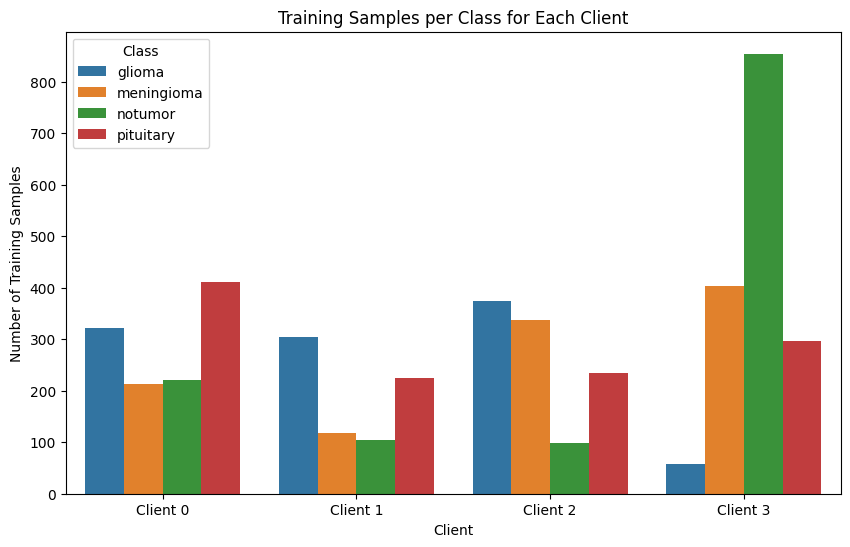

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Prepare data for visualization
client_ids = []
class_labels = ['glioma', 'meningioma', 'notumor', 'pituitary']
data_for_plot = {'Client': [], 'Class': [], 'Count': []}

# Assume clients_train_test is defined and contains the train splits for each client
for client_id, splits in clients_train_test.items():
    train_data = splits['train']
    label_counts = {label: 0 for label in class_labels}
    for _, label in train_data:
        # Convert label to string if it is int
        if isinstance(label, int):
            label_name = class_labels[label]
        else:
            label_name = label
        label_counts[label_name] += 1
    for lbl in class_labels:
        data_for_plot['Client'].append(f'Client {client_id}')
        data_for_plot['Class'].append(lbl)
        data_for_plot['Count'].append(label_counts[lbl])

# Create dataframe for plotting
plot_df = pd.DataFrame(data_for_plot)

# Plot grouped bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x='Client', y='Count', hue='Class', data=plot_df)
plt.title('Training Samples per Class for Each Client')
plt.xlabel('Client')
plt.ylabel('Number of Training Samples')
plt.legend(title='Class')
plt.show()


Data distribution amongst four clients

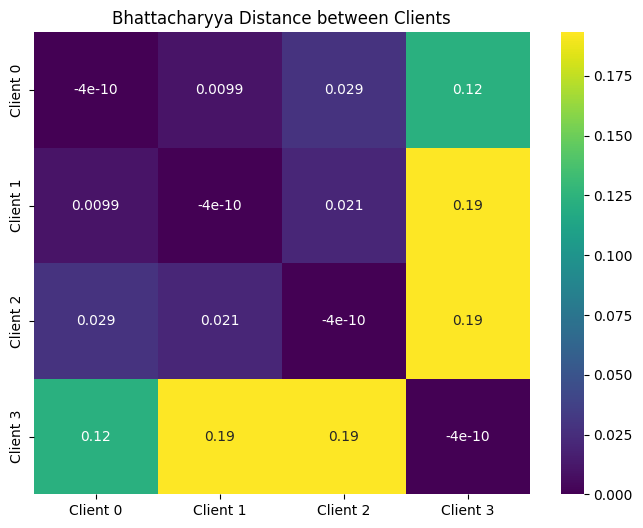

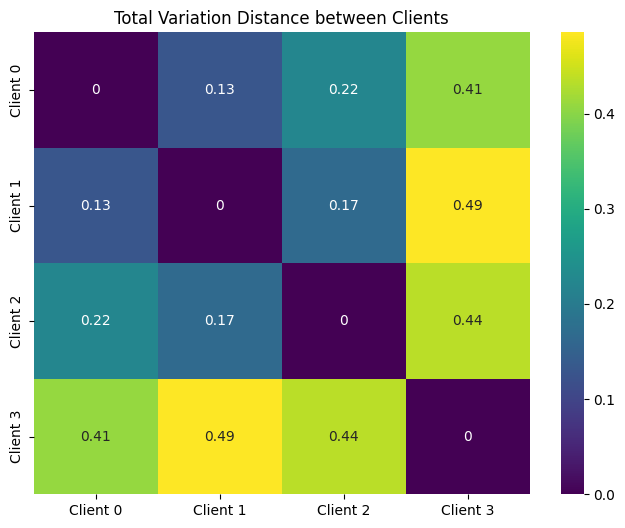

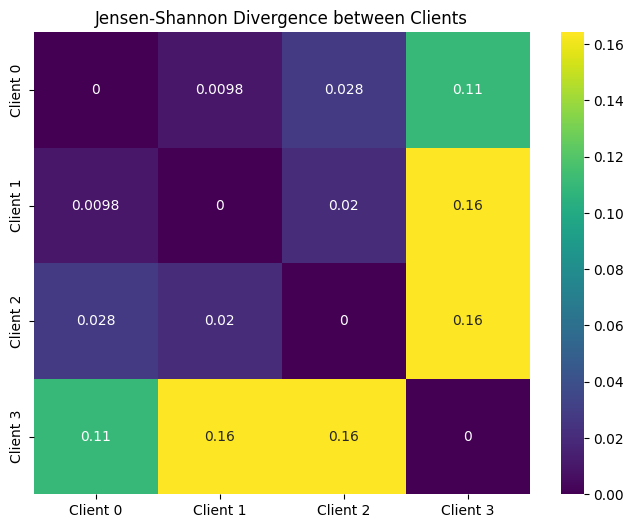

In [43]:
import numpy as np
from scipy.stats import entropy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming clients_train_test exists with train splits
# and class_labels matches your integer-to-label mapping
def get_class_distribution(client_data, class_labels):
    counts = {label: 0 for label in class_labels}
    for _, label in client_data:
        if isinstance(label, int):
            label_name = class_labels[label]
        else:
            label_name = label
        counts[label_name] += 1
    total = sum(counts.values())
    # Avoid division by zero for clients with no samples
    return np.array([counts[label] / total if total > 0 else 0 for label in class_labels])

# Get normalized class distributions for each client from real splits
distributions = []
for client_id, splits in clients_train_test.items():
    dist = get_class_distribution(splits['train'], class_labels)
    distributions.append(dist)
n = len(distributions)
client_names = [f"Client {i}" for i in range(n)]

# Divergence functions
def bhattacharyya_distance(p, q, eps=1e-10):
    p = p + eps
    q = q + eps
    bc = np.sum(np.sqrt(p * q))
    return -np.log(bc)
def total_variation_distance(p, q):
    return 0.5 * np.sum(np.abs(p - q))
def jensen_shannon_divergence(p, q, eps=1e-10):
    p = p + eps
    q = q + eps
    m = 0.5 * (p + q)
    return 0.5 * entropy(p, m) + 0.5 * entropy(q, m)

# Compute matrices
bhatt_matrix = np.zeros((n, n))
tv_matrix = np.zeros((n, n))
jsd_matrix = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        bhatt_matrix[i, j] = bhattacharyya_distance(distributions[i], distributions[j])
        tv_matrix[i, j] = total_variation_distance(distributions[i], distributions[j])
        jsd_matrix[i, j] = jensen_shannon_divergence(distributions[i], distributions[j])

# Visualization function
def plot_heatmap(matrix, title, labels):
    df = pd.DataFrame(matrix, index=labels, columns=labels)
    plt.figure(figsize=(8,6))
    sns.heatmap(df, annot=True, cmap='viridis')
    plt.title(title)
    plt.show()

# Plot all 3 divergences
plot_heatmap(bhatt_matrix, 'Bhattacharyya Distance between Clients', client_names)
plot_heatmap(tv_matrix, 'Total Variation Distance between Clients', client_names)
plot_heatmap(jsd_matrix, 'Jensen-Shannon Divergence between Clients', client_names)
